# Variable density values
Here we will extend the `simple_inversion.ipynb` example by using variable density contrast values. We create a map of density contrast values, and supply that instead of the constant density contrast value. This is useful for situations where you know the density contrast across your topographic layer is interest is variable, such as modelled the sediment-basement contact where the basement density changes regionally. 

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

import os

import verde as vd
import xarray as xr
from polartoolkit import maps
from polartoolkit import utils as polar_utils

import invert4geom

os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

/home/sungw937/miniforge3/envs/invert4geom/lib/python3.12/site-packages/UQpy/__init__.py:6: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



## Create observed gravity data
To run the inversion, we need to have observed gravity data. In this simple example, we will first create a synthetic topography, which represents the `true` Earth topography which we hope to recover during the inversion. From this topography, we will create a layer of vertical right-rectangular prisms, which allows us to calculated the gravity effect of the topography. This will act as our observed gravity data. 

### True topography

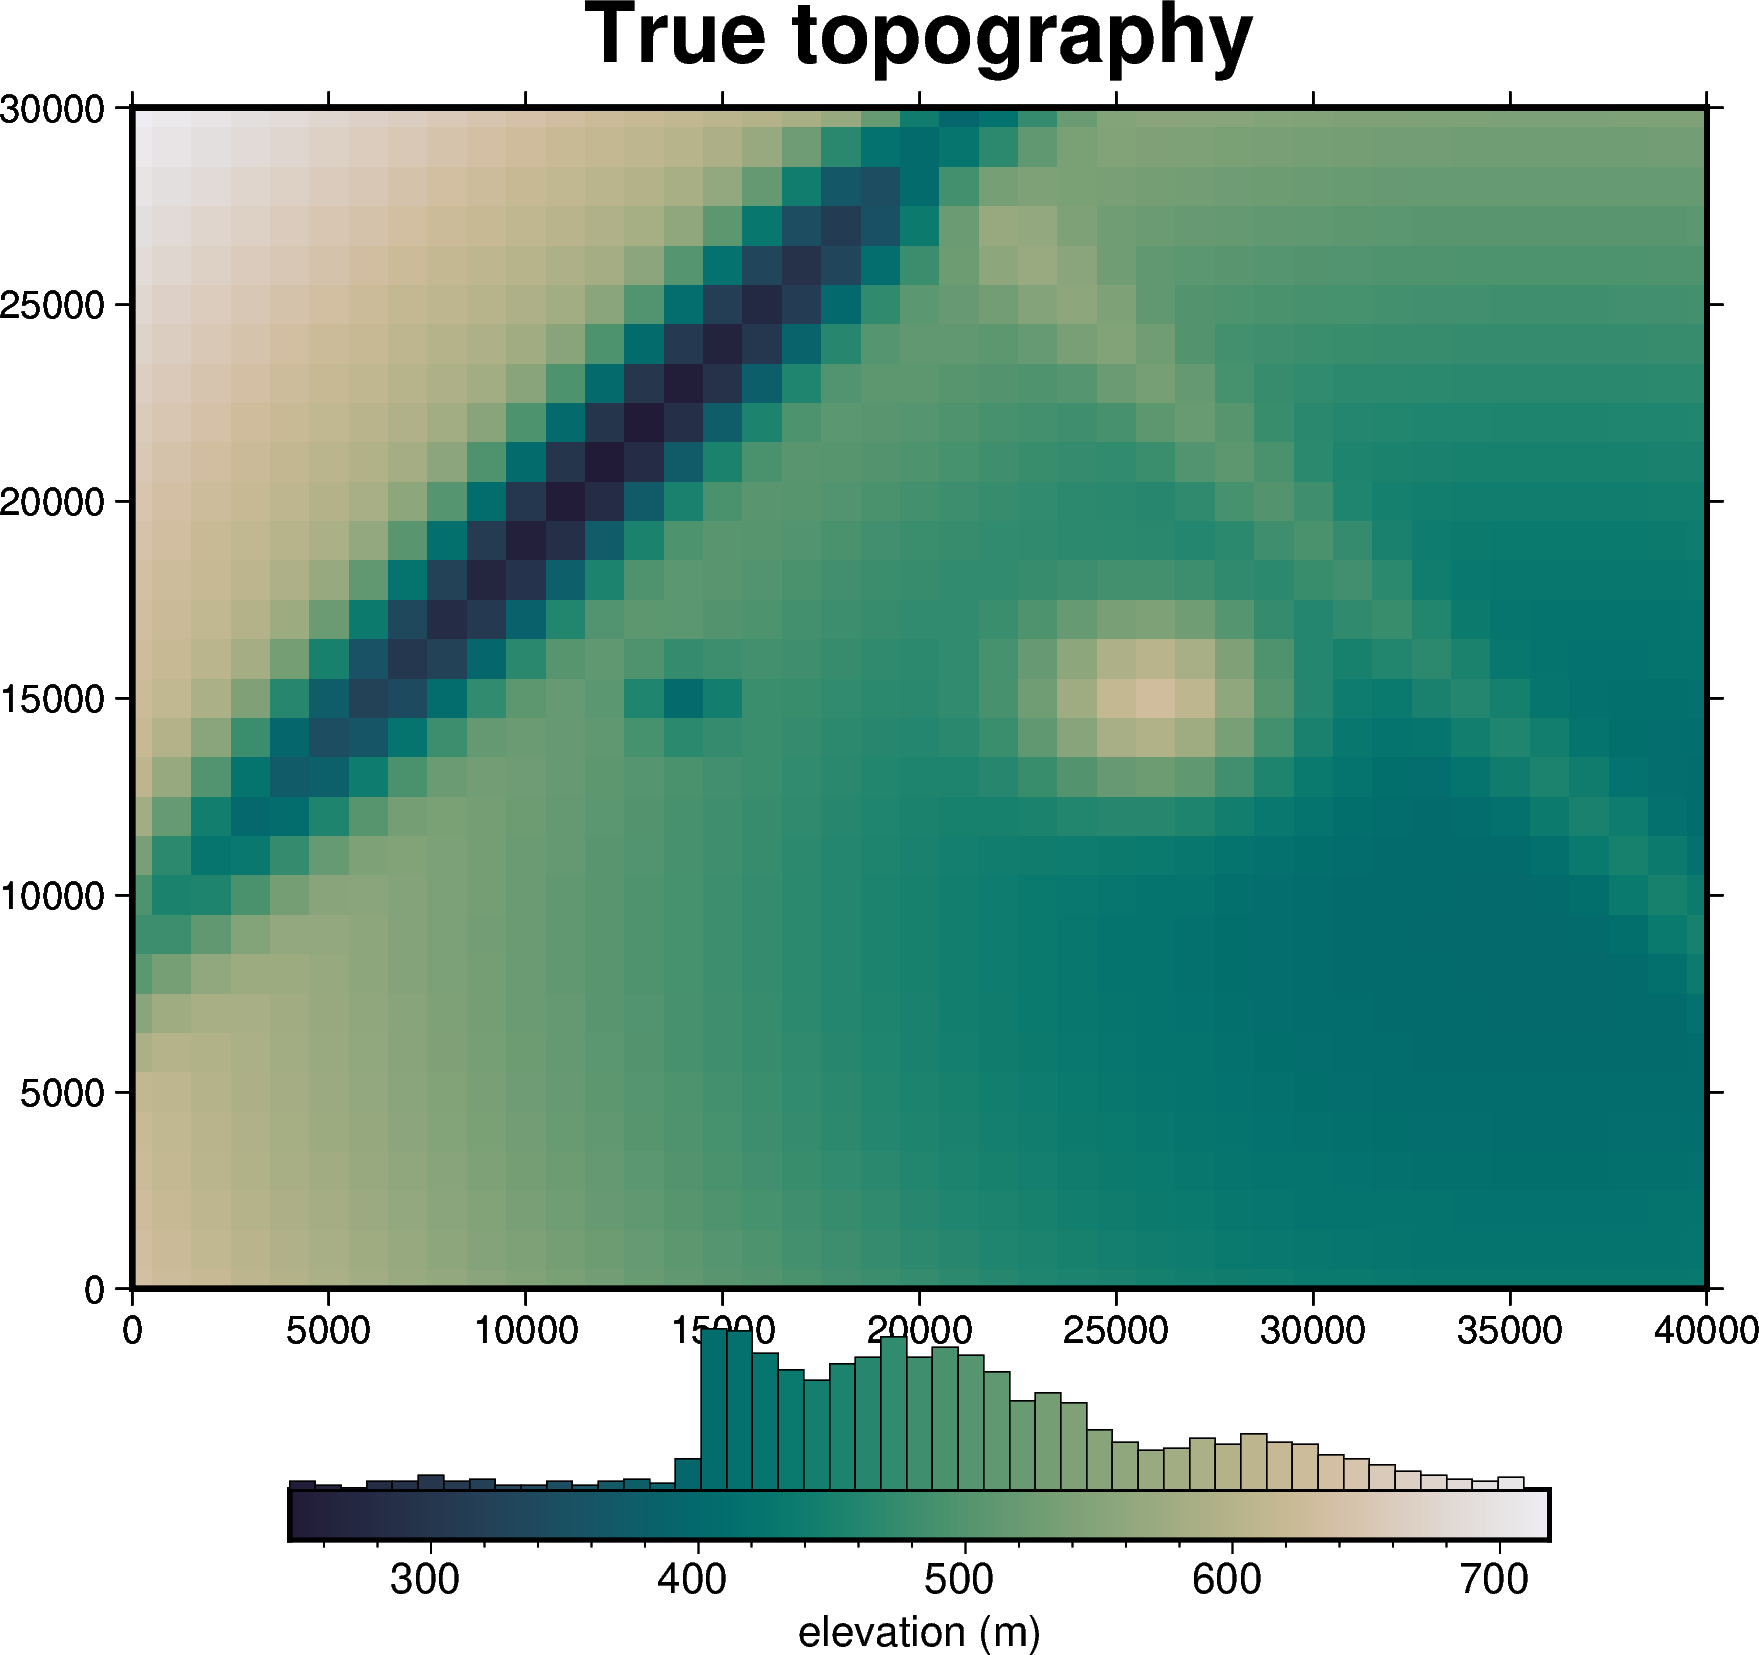

<xarray.DataArray 'upward' (northing: 31, easting: 41)> Size: 10kB
array([[637.12943453, 627.28784729, 617.55840384, ..., 428.39025144,
        429.33158321, 430.64751872],
       [632.95724141, 623.04617819, 613.24496334, ..., 422.67589466,
        423.6241977 , 424.94987872],
       [629.2139621 , 619.27333357, 609.41212904, ..., 417.59868139,
        418.55317844, 419.88752006],
       ...,
       [701.54094486, 692.82534357, 684.20926165, ..., 516.68829114,
        517.52190298, 518.68725132],
       [709.90739328, 701.33808009, 692.86661587, ..., 528.15742206,
        528.97704204, 530.12283044],
       [718.55151946, 710.13334959, 701.81130286, ..., 540.00720706,
        540.8123708 , 541.93795008]], shape=(31, 41))
Coordinates:
  * northing  (northing) float64 248B 0.0 1e+03 2e+03 ... 2.8e+04 2.9e+04 3e+04
  * easting   (easting) float64 328B 0.0 1e+03 2e+03 ... 3.8e+04 3.9e+04 4e+04

In [2]:
spacing = 1000
region = (0, 40000, 0, 30000)

true_topography, _, _, _ = invert4geom.load_synthetic_model(
    spacing=spacing,
    region=region,
)

# plot the true topography
fig = maps.plot_grd(
    true_topography,
    fig_height=10,
    title="True topography",
    cmap="rain",
    hist=True,
    reverse_cpt=True,
    cbar_label="elevation (m)",
    frame=["nSWe", "xaf10000", "yaf10000"],
)
fig.show()

true_topography

### Density distribution
Here we first create a grid of actual density values (not contrasts), representing variable density values of the Earth surface. Note that these are densities, not density contrasts.

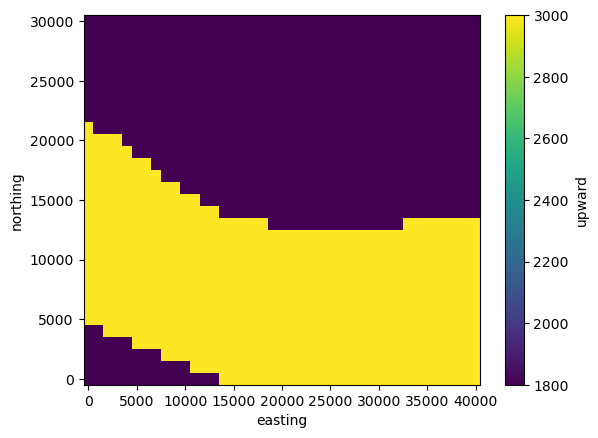

In [16]:
# create some random synthetic data
synthetic_data = invert4geom.synthetic_topography_regional(
    spacing,
    region,
    yoffset=20,
)

# the first density represents sediment (~1800 kg/m3)
density_1 = 1800

# the second density represents crystalline basement (~3000 kg/m3)
# (~1 kg/m3)
density_2 = 3000

# use it to create a surface density distribution
density_dist = xr.where(synthetic_data > 0, density_1, density_2)

density_dist.plot()

### Density contrast
Now we can subtract the density of air (~1 kg/m3) from this grid from to get the spatially variable density contrast. With air, this doesn't make much of a difference, but if the contrast is between two geologic layers (mantle and crust, or basement and sediment) the distinction between densities and density contrasts is more important.

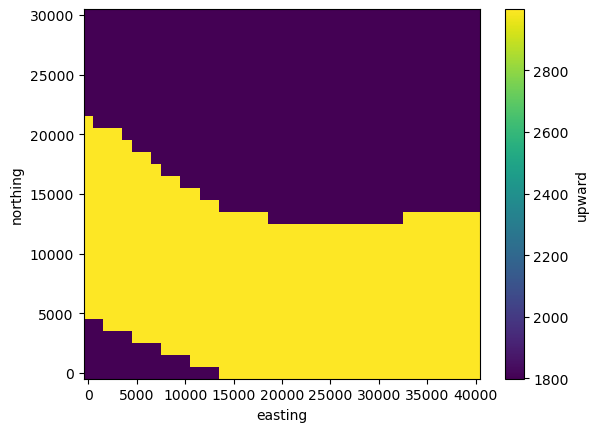

In [17]:
density_contrast = density_dist - 1  # density contrast relative to air (1 kg/m3)

density_contrast.plot()

### Prism layer

In [18]:
model = invert4geom.create_model(
    zref=true_topography.values.mean(),
    density_contrast=density_contrast,
    topography=true_topography.to_dataset(name="upward"),
)
model

<xarray.Dataset> Size: 92kB
Dimensions:                (northing: 31, easting: 41)
Coordinates:
  * northing               (northing) float64 248B 0.0 1e+03 ... 2.9e+04 3e+04
  * easting                (easting) float64 328B 0.0 1e+03 ... 3.9e+04 4e+04
    top                    (northing, easting) float64 10kB 637.1 ... 541.9
    bottom                 (northing, easting) float64 10kB 492.3 ... 492.3
Data variables:
    density                (northing, easting) int64 10kB 1799 1799 ... 1799
    thickness              (northing, easting) float64 10kB 144.9 ... 49.67
    starting_topography    (northing, easting) float64 10kB 637.1 ... 541.9
    topography             (northing, easting) float64 10kB 637.1 ... 541.9
    mask                   (northing, easting) float64 10kB 1.0 1.0 ... 1.0 1.0
    upper_confining_layer  (northing, easting) float64 10kB nan nan ... nan nan
    lower_confining_layer  (northing, easting) float64 10kB nan nan ... nan nan
Attributes:
    inner_region:      (0.0, 40000.0, 0.0, 30000.0)
    zref:              492.2704164812973
    density_contrast:  <xarray.DataArray 'upward' (northing: 31, easting: 41)...
    region:            (0.0, 40000.0, 0.0, 30000.0)
    spacing:           1000.0
    dataset_type:      model
    model_type:        prisms

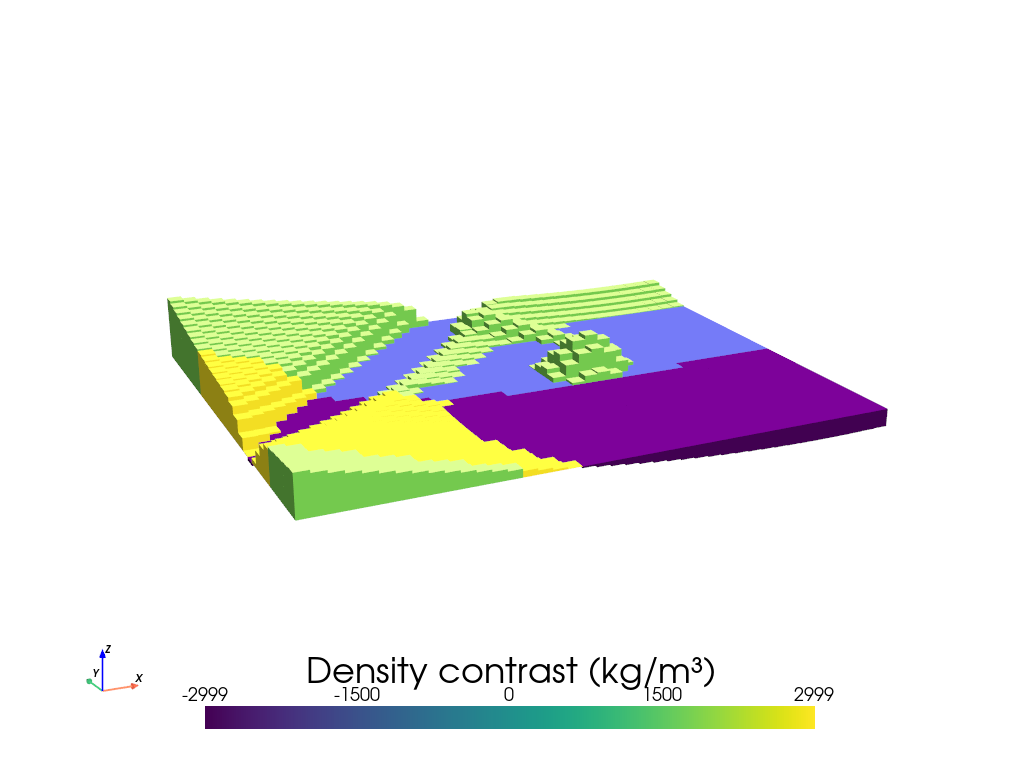

In [19]:
model.inv.plot_model(
    color_by="density",
    zscale=20,
)

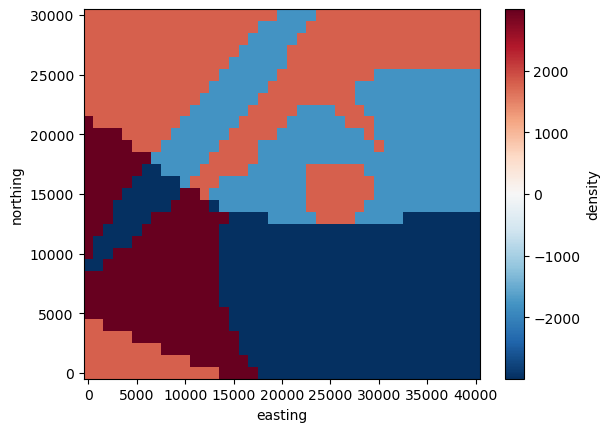

In [20]:
model.density.plot()

### Forward gravity of prism layer

In [21]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=1000,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
)

grav_data = invert4geom.create_data(observations)

grav_data.inv.forward_gravity(model, "grav")
grav_data

<xarray.Dataset> Size: 21kB
Dimensions:   (northing: 31, easting: 41)
Coordinates:
  * northing  (northing) float64 248B 0.0 1e+03 2e+03 ... 2.8e+04 2.9e+04 3e+04
  * easting   (easting) float64 328B 0.0 1e+03 2e+03 ... 3.8e+04 3.9e+04 4e+04
Data variables:
    upward    (northing, easting) float64 10kB 1e+03 1e+03 1e+03 ... 1e+03 1e+03
    grav      (northing, easting) float64 10kB 6.476 7.086 6.779 ... 2.22 1.921
Attributes:
    region:        (0.0, 40000.0, 0.0, 30000.0)
    spacing:       1000.0
    buffer_width:  3000.0
    inner_region:  (3000.0, 37000.0, 3000.0, 27000.0)
    dataset_type:  data
    model_type:    prisms

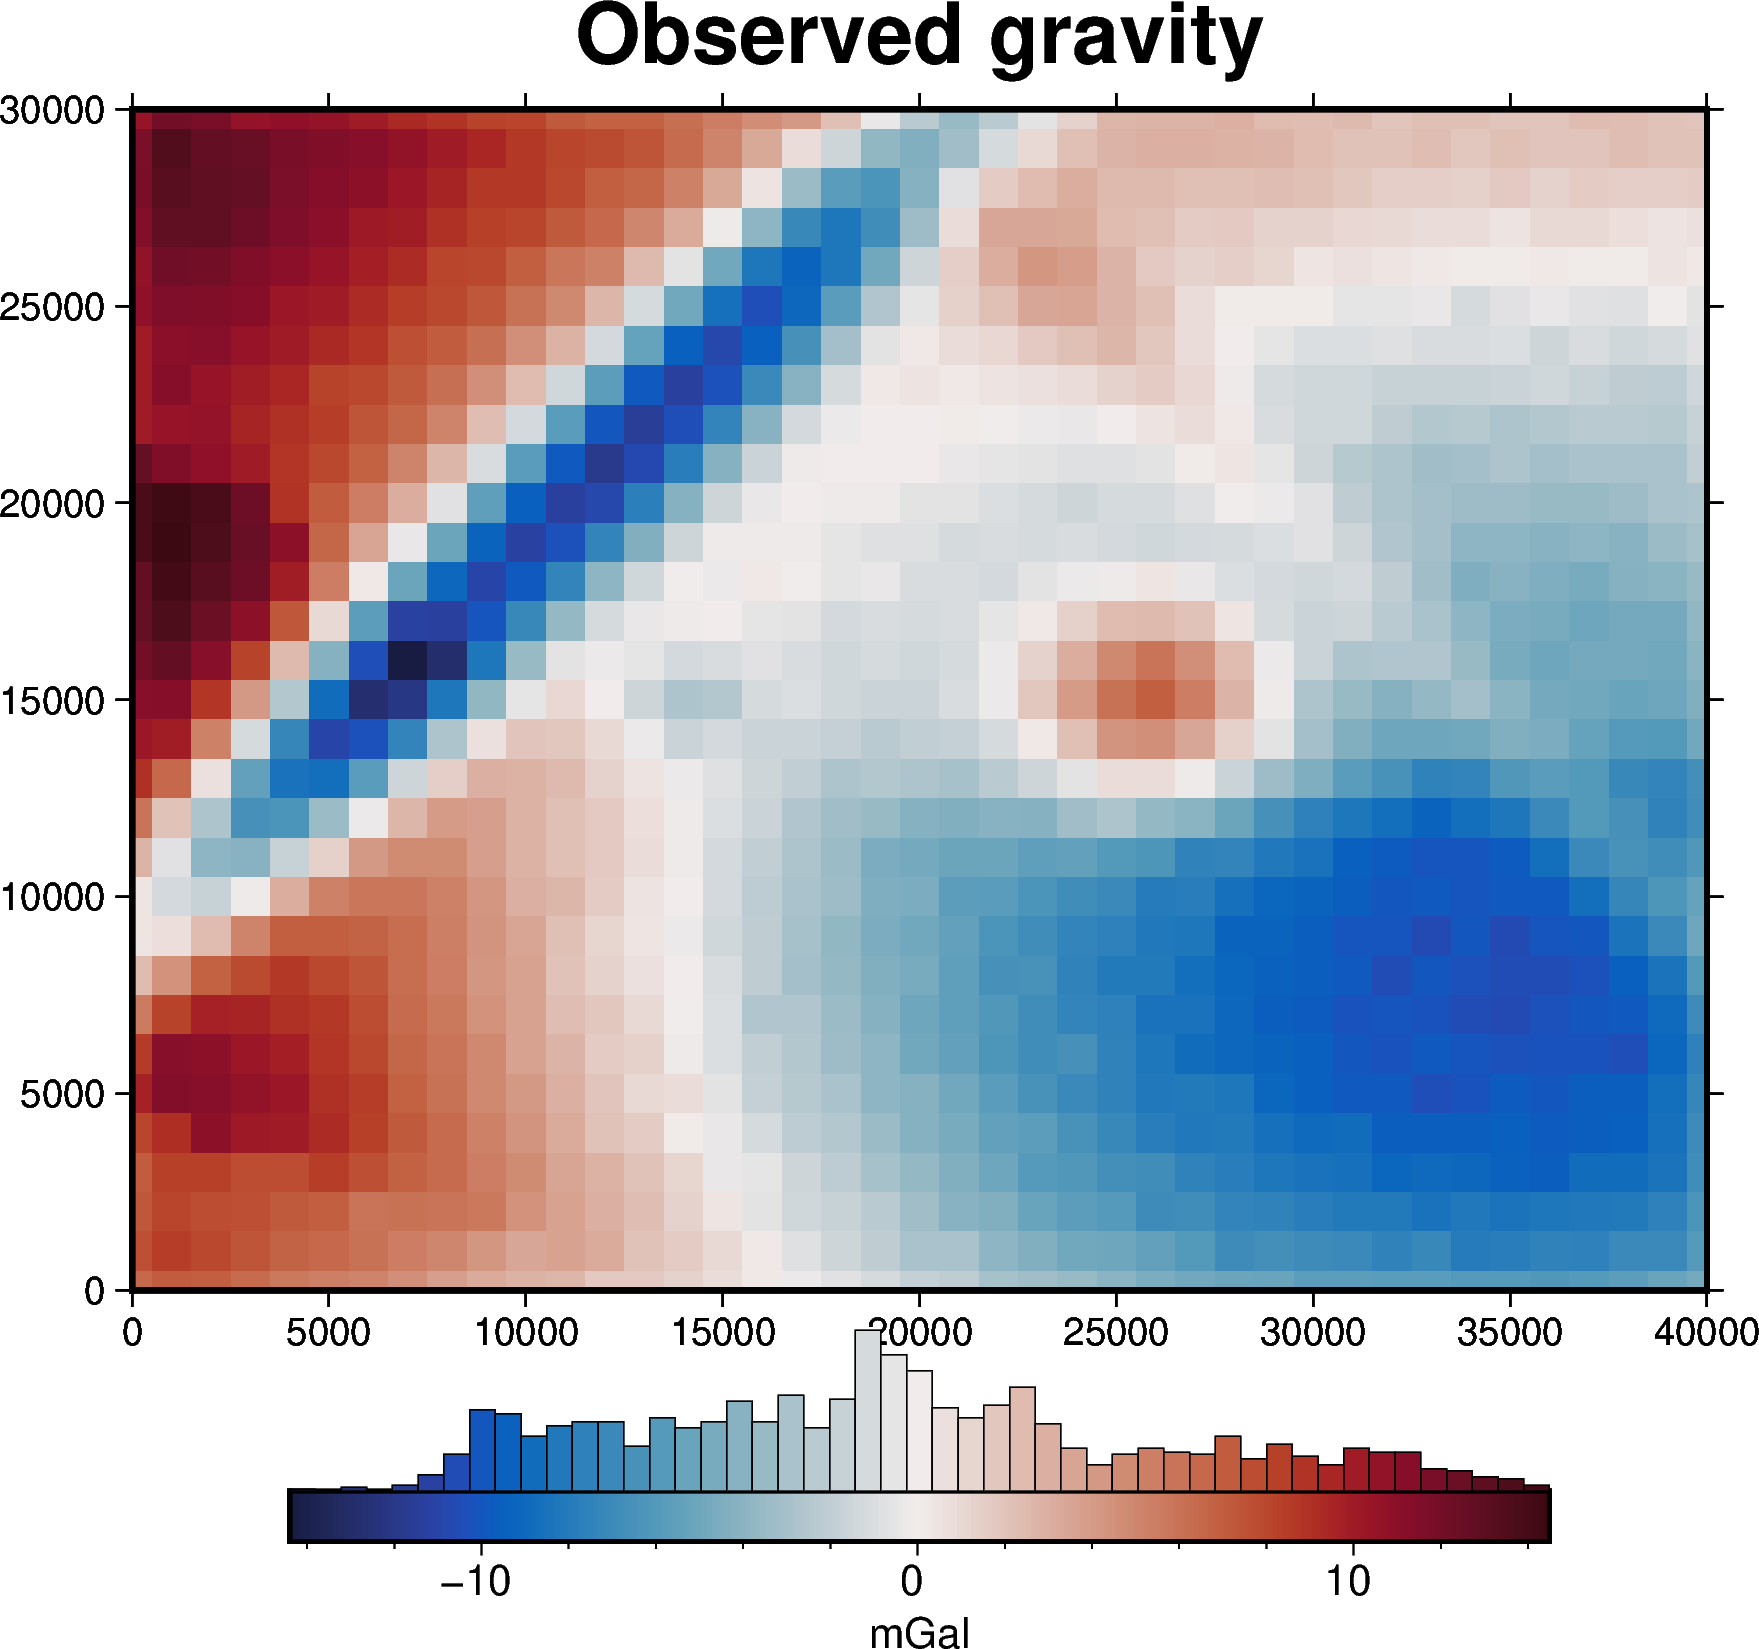

In [22]:
# contaminate gravity with 0.2 mGal of random noise
grav_data["gravity_anomaly"], stddev = invert4geom.contaminate(
    grav_data.grav,
    stddev=0.2,
    percent=False,
    seed=0,
)

# plot the observed gravity
fig = maps.plot_grd(
    grav_data.gravity_anomaly,
    fig_height=10,
    title="Observed gravity",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)
fig.show()

## Gravity misfit
Now we need to create a starting model of the topography to start the inversion with. Since here we have no knowledge of either the topography or the appropriate reference level (`zref`), the starting model is flat, and therefore it's forward gravity is 0. If you had a non-flat starting model, you would need to calculate it's forward gravity effect, and subtract it from our observed gravity to get a starting gravity misfit. 

In this simple case, we assume that we know the true density contrast and appropriate reference value for the topography (`zref`), and use these values to create our flat starting model. Note that in a real world scenario, these would be unknowns which would need to be carefully chosen, as explained in the following notebooks.

In [ ]:
# create flat starting topography
starting_topography = invert4geom.create_topography(
    method="flat",
    upward=true_topography.values.mean(),
    region=region,
    spacing=spacing,
)

model = invert4geom.create_model(
    zref=starting_topography.upward.values.mean(),
    density_contrast=density_contrast,
    topography=starting_topography,
)

In [40]:
grav_data.inv.forward_gravity(
    model,
    progressbar=True,
)

  0%|          | 0/1271 [00:00<?, ?it/s]

In [41]:
# in many cases, we want to remove a regional signal from the misfit to isolate the
# residual signal. In this simple case, we assume there is no regional misfit and set
# it to 0
grav_data.inv.regional_separation(
    method="constant",
    constant=0,
)
grav_data

<xarray.Dataset> Size: 112kB
Dimensions:                   (northing: 31, easting: 41)
Coordinates:
  * northing                  (northing) float64 248B 0.0 1e+03 ... 3e+04
  * easting                   (easting) float64 328B 0.0 1e+03 ... 3.9e+04 4e+04
Data variables:
    upward                    (northing, easting) float64 10kB 1e+03 ... 1e+03
    grav                      (northing, easting) float64 10kB 6.476 ... 1.921
    gravity_anomaly           (northing, easting) float64 10kB 6.509 ... 2.035
    forward_gravity           (northing, easting) float64 10kB -0.0 ... -0.0
    misfit                    (northing, easting) float64 10kB 6.509 ... 2.035
    reg                       (northing, easting) float64 10kB 0.0 0.0 ... 0.0
    res                       (northing, easting) float64 10kB 6.509 ... 2.035
    starting_forward_gravity  (northing, easting) float64 10kB -0.0 ... -0.0
    starting_misfit           (northing, easting) float64 10kB 6.509 ... 2.035
    starting_reg              (northing, easting) float64 10kB 0.0 0.0 ... 0.0
    starting_res              (northing, easting) float64 10kB 6.509 ... 2.035
Attributes:
    region:        (0.0, 40000.0, 0.0, 30000.0)
    spacing:       1000.0
    buffer_width:  3000.0
    inner_region:  (3000.0, 37000.0, 3000.0, 27000.0)
    dataset_type:  data
    model_type:    prisms

makecpt [ERROR]: Option T: min >= max
supplied min value is greater or equal to max value
Grid/points are a constant value, can't make a colorbar histogram!
makecpt [ERROR]: Option T: min >= max
supplied min value is greater or equal to max value
Grid/points are a constant value, can't make a colorbar histogram!


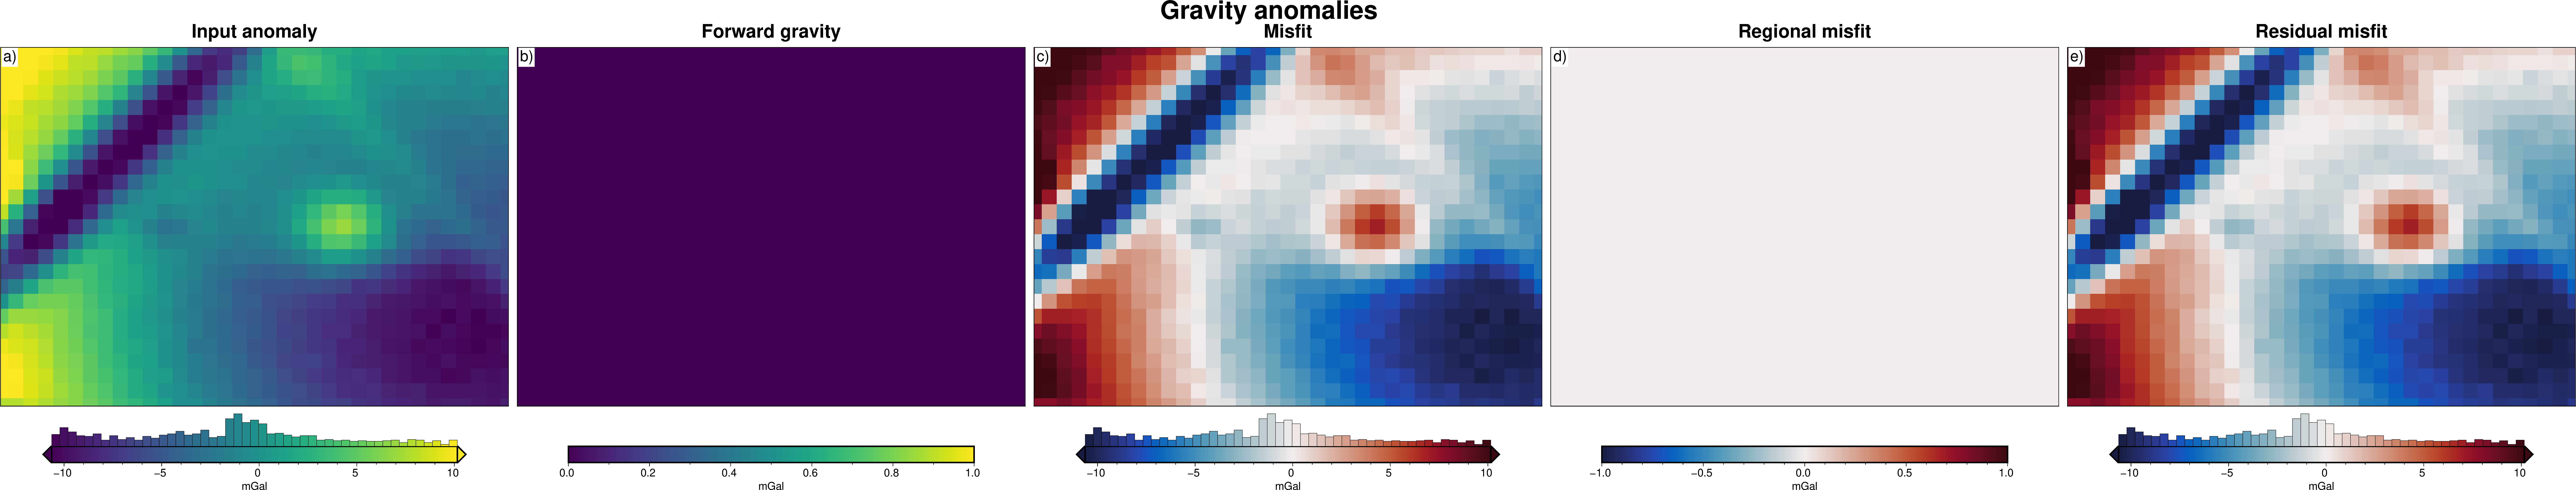

In [42]:
grav_data.inv.plot_anomalies()

## Perform inversion
Now that we have a starting model and residual gravity misfit data we can start the inversion.

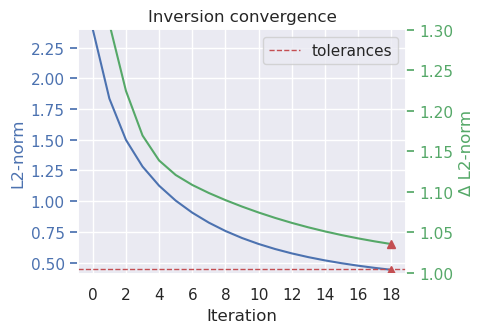

In [43]:
# setup the inversion
inv = invert4geom.Inversion(
    grav_data,
    model,
    solver_damping=0.1,
    # set stopping criteria
    max_iterations=30,
    l2_norm_tolerance=0.45,  # gravity error is .2 mGal, L2-norm is sqrt(mGal) so ~0.45
    delta_l2_norm_tolerance=1.005,
)

# run the inversion
inv.invert(
    plot_dynamic_convergence=True,
)

In [44]:
inv.stats_df

,iteration,rmse,l2_norm,delta_l2_norm,iter_time_sec
0,0.0,5.751595,2.398248,inf,NaN
1,1.0,3.366240,1.834732,1.307138,0.764598
2,2.0,2.245393,1.498464,1.224409,0.434352
3,3.0,1.642156,1.281466,1.169335,0.648203
4,4.0,1.266864,1.125551,1.138524,0.346629
5,5.0,1.008776,1.004378,1.120644,0.333455
6,6.0,0.821183,0.906192,1.108351,0.362459
7,7.0,0.680620,0.824997,1.098418,0.313415
8,8.0,0.573226,0.757117,1.089656,0.363959
9,9.0,0.489929,0.699949,1.081674,0.368138


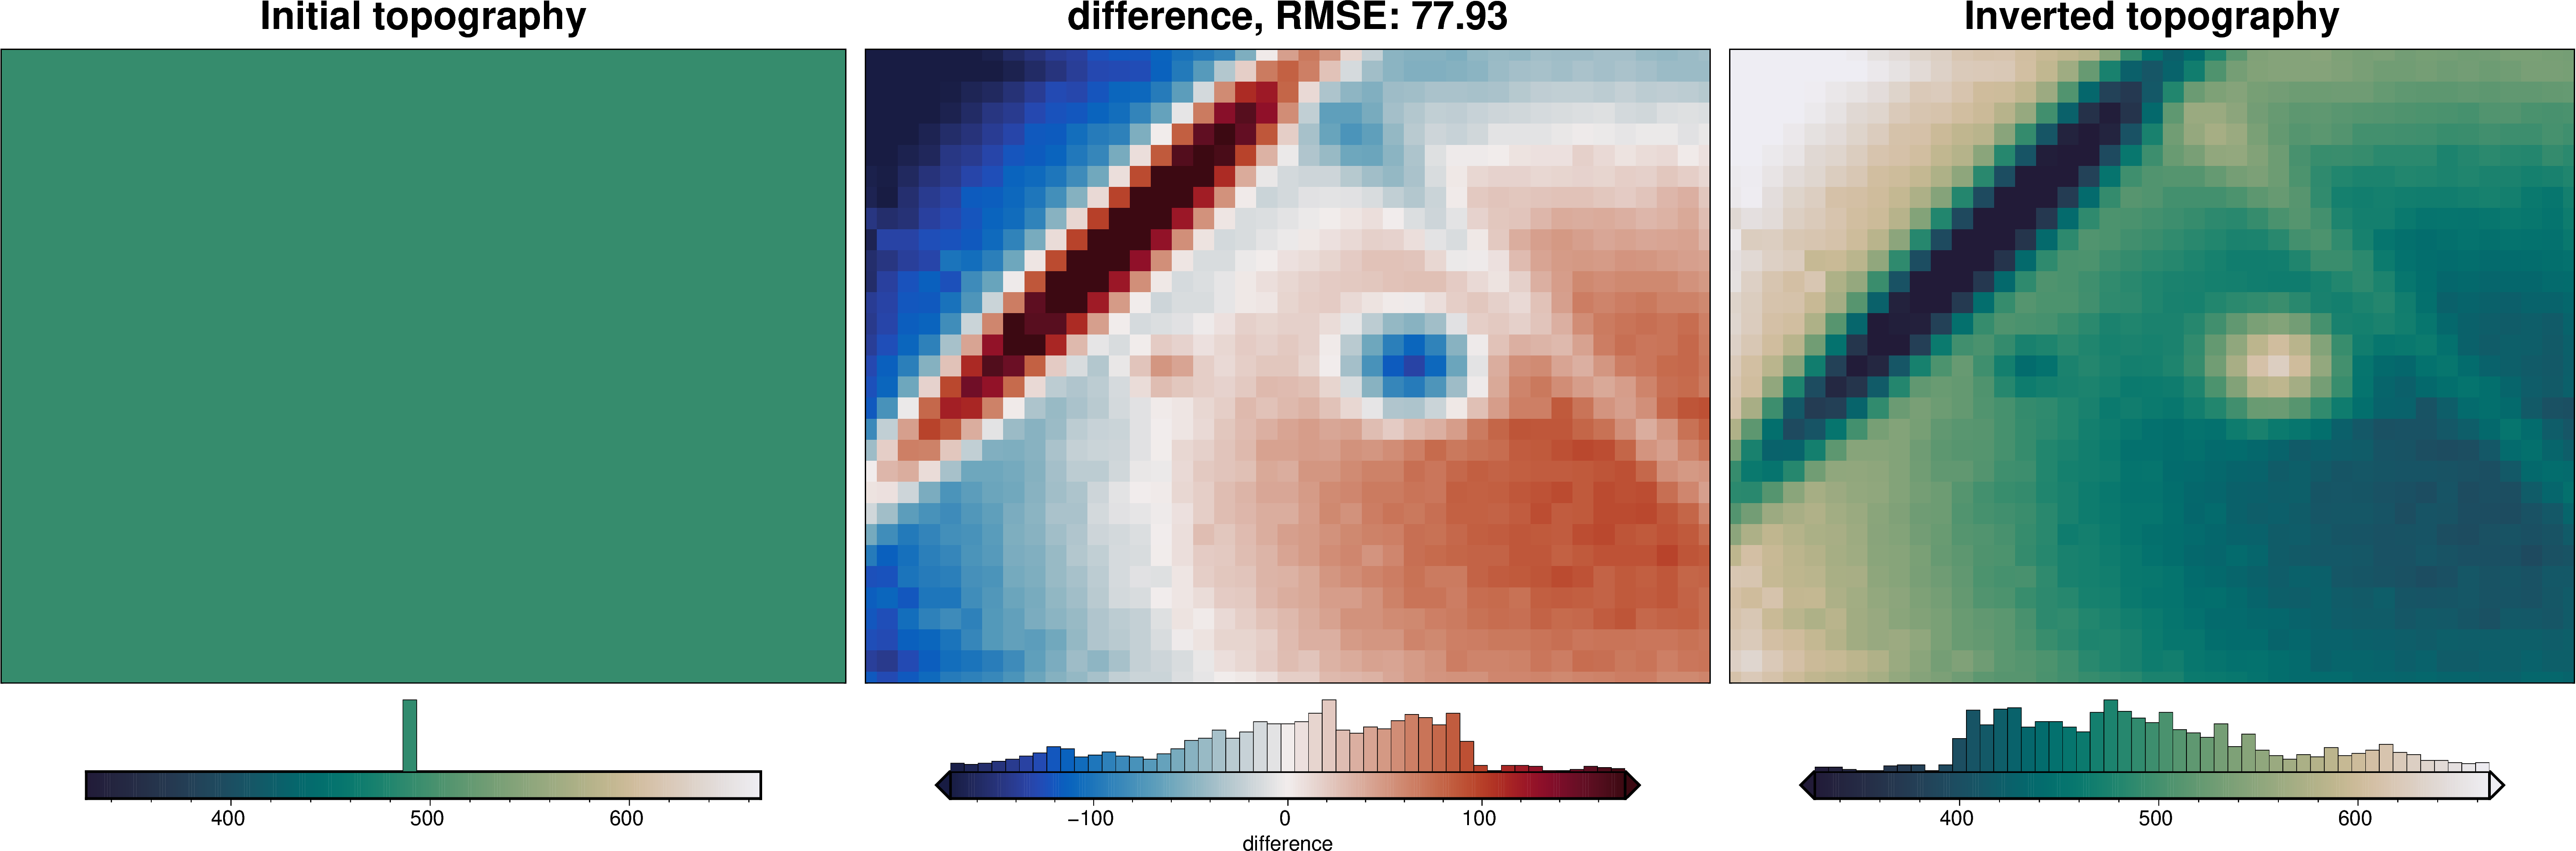

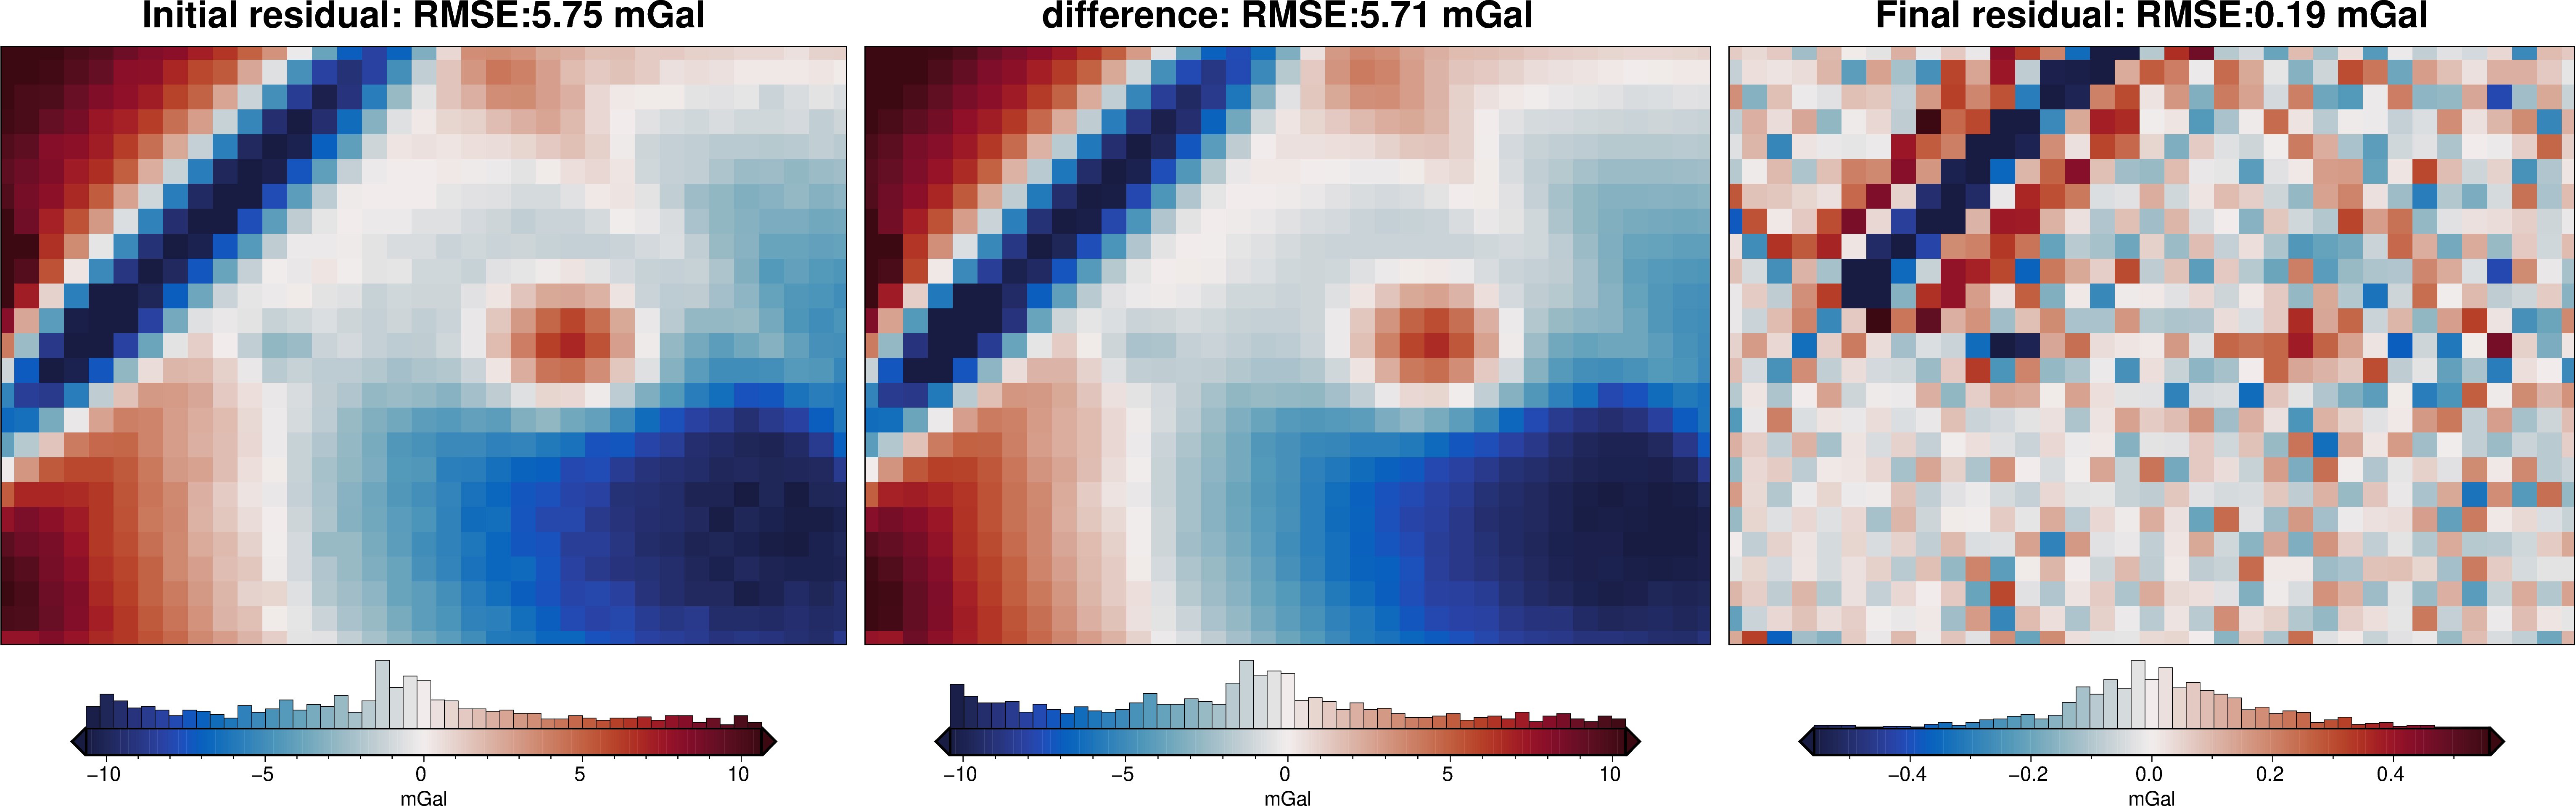

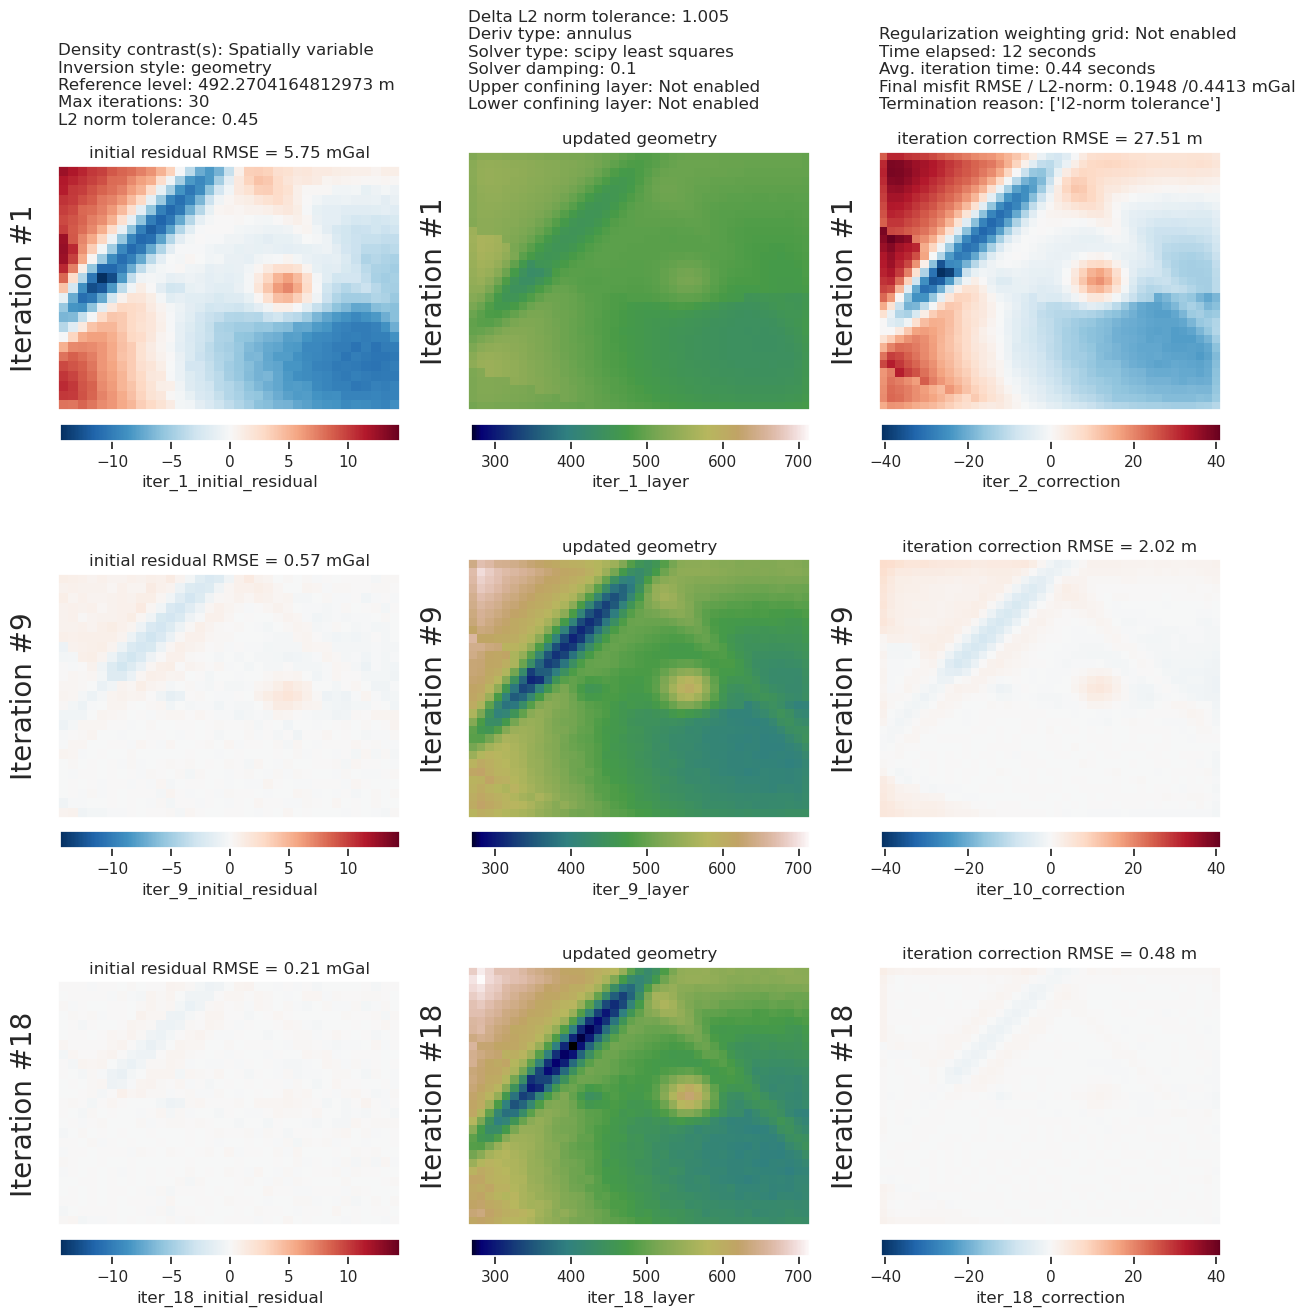

In [45]:
inv.plot_inversion_results(
    iters_to_plot=3,
    # plot_iter_results=False,
    # plot_topo_results=False,
    # plot_grav_results=False,
)

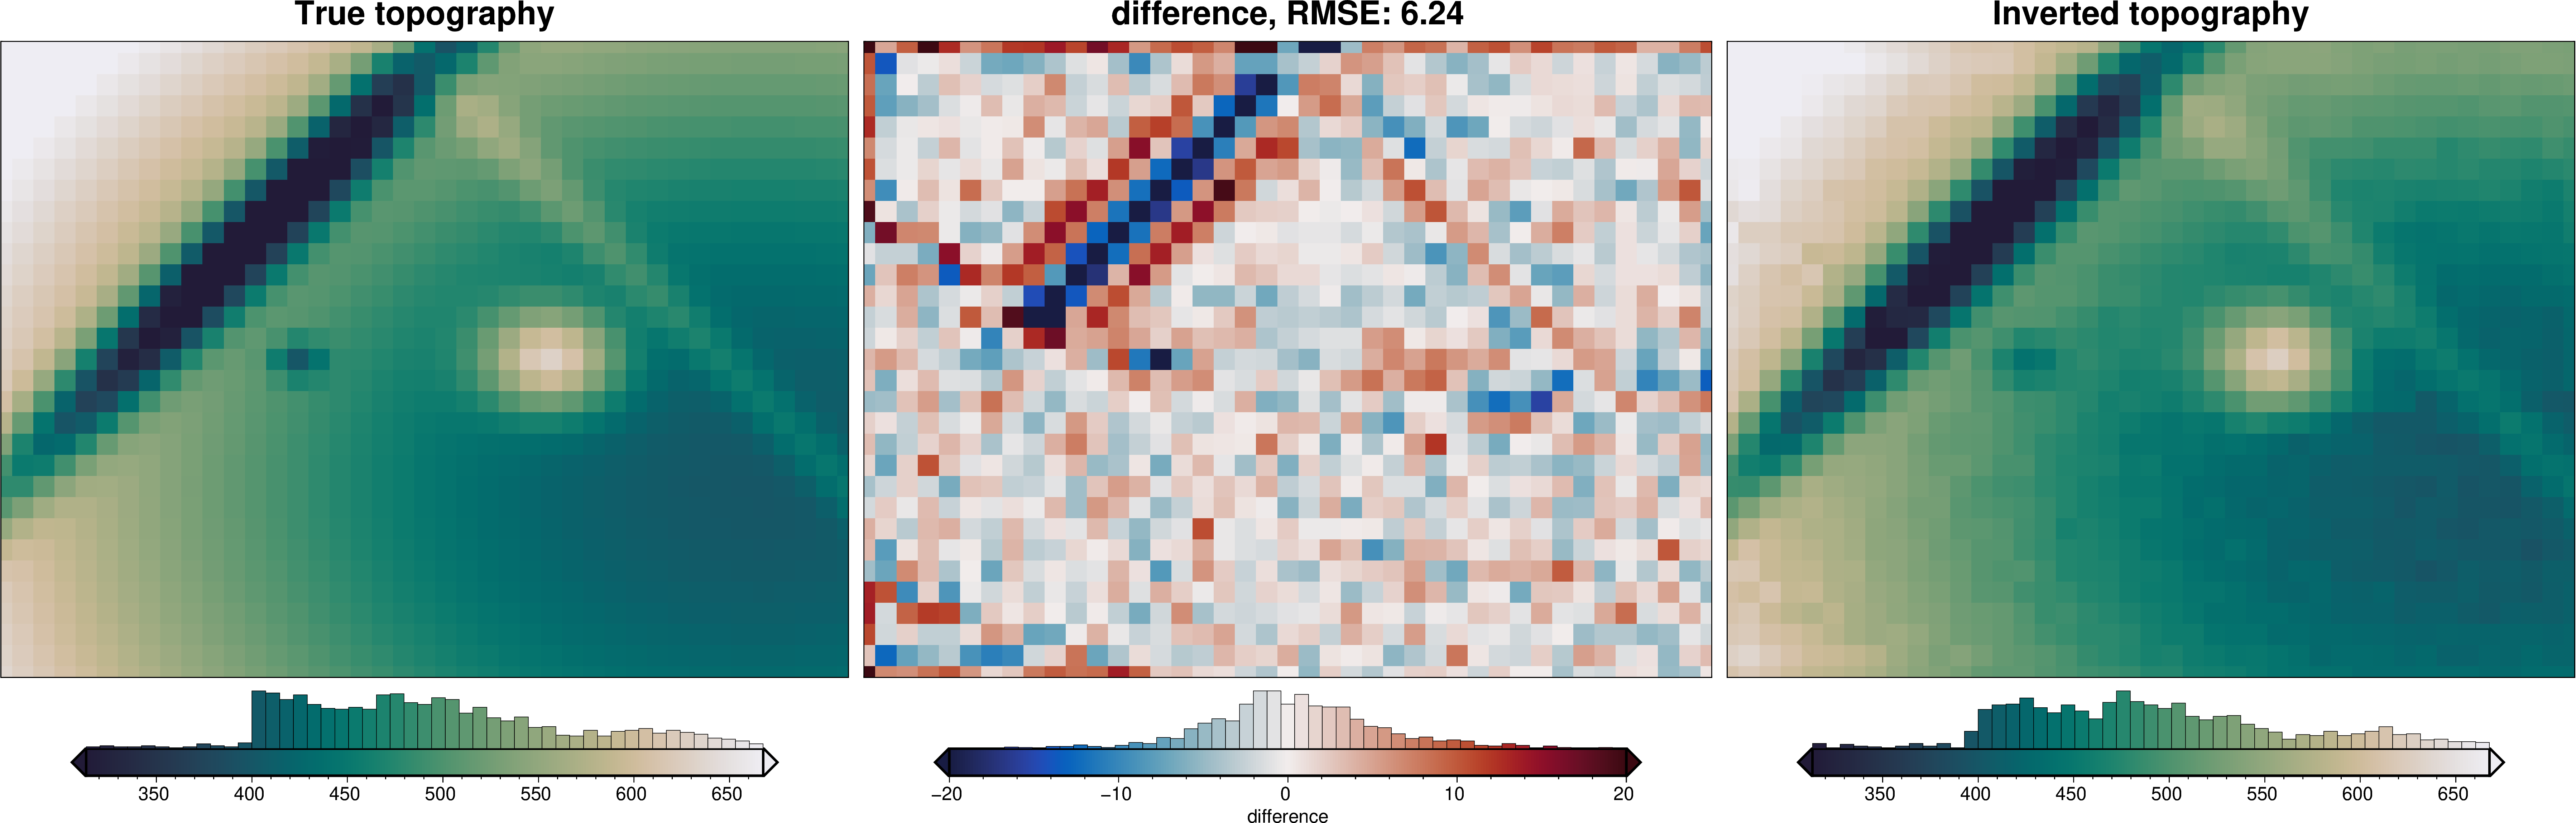

In [46]:
_ = polar_utils.grd_compare(
    true_topography,
    inv.model.topography,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    reverse_cpt=True,
    cmap="rain",
    diff_lims=(-20, 20),
)

The next notebook, `density_inversion`, shows how we can perform an inversion to recover the density contrast of a prism / tesseroid layer of known geometry, instead of inverted for the geometry of the layer.